# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json

from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, depolarizing_error)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV1, Options

In [2]:
token = '' # Put in your IBM token
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite= True)

# Functions to write the divide-and-conquer circuits

In [2]:
def new_observable(beta, a, b):
    def Rz(beta):
        return np.array([[np.cos(beta/2) - 1j * np.sin(beta/2), 0], [0, np.cos(beta/2) + 1j * np.sin(beta/2)]])
    
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])
    Rzbeta = Rz(beta)
    Rzbetainv = Rz(-beta)
    T = a * I + b * X
    return T @ Rzbetainv @ X @ Rzbeta @ T

def eigs(beta, a, b):
    TOT = new_observable(beta, a, b)
    eigenvalues, eigenvectors = np.linalg.eig(TOT)
    eigvec0, eigvec1 = eigenvectors[:,0], eigenvectors[:,1]
    eigvec0 = eigvec0 / np.linalg.norm(eigvec0)
    eigvec1 = eigvec1 / np.linalg.norm(eigvec1)
    eigenvectors = (eigvec0, eigvec1)
    return eigenvalues, eigenvectors

def X_eigs(a, b):
    eigval0 = 2*a*b + (a**2 + b**2)
    eigval1 = 2*a*b - (a**2 + b**2)
    return eigval0, eigval1


def transform_basis(qc, beta, qubit, a, b):
    eigenvectors = eigs(beta, a, b)[1]
    eigvec0, eigvec1 = eigenvectors[0], eigenvectors[1]
    zero = np.array([1, 0])
    one = np.array([0, 1])
    U = np.outer(zero, eigvec0.conj()) + np.outer(one, eigvec1.conj())
    if beta == 0:
        sign = ""
    else:
        sign = beta/abs(beta)
    gate_label = "U(" + str(sign) + str(np.round(beta, 3)) + ")"
    qc.unitary(U, qubit, label = gate_label)

def twirled_cz(qc, qubit1, qubit2, repeats=1):
    """
    twirl is an integer in {0, 1, ... 15}, representing one of possible 16 Pauli twirls of {I, X, Y, Z}^{otimes 2} in 4-ary.
    repeats is some (odd) number for which the CZ is repeated.
    """
    for _ in range(repeats):
        twirl = np.random.randint(16)
        match twirl:
            case 0: # II
                qc.cz(qubit1, qubit2)

            case 1:
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.x(qubit2)
            
            case 2:
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit2)

            case 3:
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.y(qubit2)

            case 4:
                qc.x(qubit1)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.z(qubit2)

            case 5:
                qc.x(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.y(qubit2)

            case 6:
                qc.x(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)

            case 7:
                qc.x(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.x(qubit2)

            case 8:
                qc.z(qubit1)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)

            case 9:
                qc.z(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit2)

            case 10:
                qc.z(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.z(qubit2)

            case 11:
                qc.z(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit2)

            case 12:
                qc.y(qubit1)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.z(qubit2)

            case 13:
                qc.y(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.y(qubit2)

            case 14:
                qc.y(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)

            case 15:
                qc.y(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.x(qubit2)

In [3]:
# Functions for preparing + running COP circuits

def generate_onerot_circuit(beta, a, b, meas_last_x, repeats=1):
    """
    Generates one circuit corresponding to one measurement outcome of experiment we are trying to simulate.
    -> one rotation by angle beta.
    A cluster state is prepared, then a rotation is conducted on the fifth site. A state tomography measurement
    (either X or Y) is conducted on the last (ninth) qubit. Post processing is done of outcomes to account for non-unitary T.
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
            meas_last_x - Whether the fifth qubit is measured in the Y or X basis
    Outputs: The circuit
    """
    qr = QuantumRegister(9)
    qc = QuantumCircuit(qr)

    qc.h(qr)

    twirled_cz(qc, 0, 1, repeats)
    twirled_cz(qc, 2, 3, repeats)
    twirled_cz(qc, 4, 5, repeats)
    twirled_cz(qc, 6, 7, repeats)
    twirled_cz(qc, 1, 2, repeats)
    twirled_cz(qc, 3, 4, repeats)
    twirled_cz(qc, 5, 6, repeats)
    twirled_cz(qc, 7, 8, repeats)

    # Measure qubits 1/2/3/4/6/7/8 in x basis
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(5)
    qc.h(6)
    qc.h(7)
    
    transform_basis(qc, beta, 4, a, b)

    # Measure last qubit in Y basis (or X basis)
    if meas_last_x == 0:
        qc.sdg(8)  
    qc.h(8)

    qc.measure_all()
    
    return qc

def generate_tworot_circuit(beta, a, b, meas_last_x, repeats=1):
    """
    Generates one circuit corresponding to one measurement outcome of experiment we are trying to simulate.
    -> two rotations by angle beta/2.
    A cluster state is prepared, then a rotation is conducted on the third/fifth sites. A state tomography measurement
    (either X or Y) is conducted on the last (ninth) qubit. Post processing is done of outcomes to account for non-unitary T.
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
            meas_last_x - Whether the fifth qubit is measured in the Y or X basis
    Outputs: The circuit
    """
    qr = QuantumRegister(9)
    qc = QuantumCircuit(qr)

    qc.h(qr)

    twirled_cz(qc, 0, 1, repeats)
    twirled_cz(qc, 2, 3, repeats)
    twirled_cz(qc, 4, 5, repeats)
    twirled_cz(qc, 6, 7, repeats)
    twirled_cz(qc, 1, 2, repeats)
    twirled_cz(qc, 3, 4, repeats)
    twirled_cz(qc, 5, 6, repeats)
    twirled_cz(qc, 7, 8, repeats)

    # Measure qubits 1/2/3/4/6/7/8 in x basis
    qc.h(0)
    qc.h(1)
    qc.h(3)
    qc.h(5)
    qc.h(6)
    qc.h(7)
    
    transform_basis(qc, beta/2, 2, a, b)
    transform_basis(qc, beta/2, 4, a, b)

    # Measure last qubit in Y basis (or X basis)
    if meas_last_x == 0:
        qc.sdg(8)  
    qc.h(8)

    qc.measure_all()
    
    return qc

def generate_threerot_circuit(beta, a, b, meas_last_x, repeats=1):
    """
    Generates one circuit corresponding to one measurement outcome of experiment we are trying to simulate.
    -> three rotation by angle beta/3.
    A cluster state is prepared, then a rotation is conducted on the third/fifth/seventh site. A state tomography measurement
    (either X or Y) is conducted on the last (ninth) qubit. Post processing is done of outcomes to account for non-unitary T.
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
            meas_last_x - Whether the fifth qubit is measured in the Y or X basis
    Outputs: The circuit
    """
    qr = QuantumRegister(9)
    qc = QuantumCircuit(qr)

    qc.h(qr)

    twirled_cz(qc, 0, 1, repeats)
    twirled_cz(qc, 2, 3, repeats)
    twirled_cz(qc, 4, 5, repeats)
    twirled_cz(qc, 6, 7, repeats)
    twirled_cz(qc, 1, 2, repeats)
    twirled_cz(qc, 3, 4, repeats)
    twirled_cz(qc, 5, 6, repeats)
    twirled_cz(qc, 7, 8, repeats)

    # Measure qubits 1/2/3/4/6/7/8 in x basis
    qc.h(0)
    qc.h(1)
    qc.h(3)
    qc.h(5)
    qc.h(7)
        
    transform_basis(qc, beta/3, 2, a, b)
    transform_basis(qc, beta/3, 4, a, b)
    transform_basis(qc, beta/3, 6, a, b)

    # Measure last qubit in Y basis (or X basis)
    if meas_last_x == 0:
        qc.sdg(8)  
    qc.h(8)

    qc.measure_all()
    
    return qc

In [4]:
def generate_circuits(ab_ar, beta_ar, num_repeats=1):
    """
    Generates n circuits (one for each rotation angle)
    Inputs: beta_ar - array of rotation angles
            ab_ar - array of variational ansatz states
    Outputs: List of 2 * len(beta_ar) circuits
    """ 
    qc_list = []
    for _ in range(num_repeats):
        for ab in ab_ar:
            for num_rots in range(1, 4):
                for beta in beta_ar:
                    for meas_last_x in range(2):
                        if num_rots == 1:
                            qc_list.append(generate_onerot_circuit(beta, ab[0], ab[1], meas_last_x))
                        elif num_rots == 2:
                            qc_list.append(generate_tworot_circuit(beta, ab[0], ab[1], meas_last_x))
                        else:
                            qc_list.append(generate_threerot_circuit(beta, ab[0], ab[1], meas_last_x))
    return qc_list

# Running the divide-and-conquer circuits

In [5]:
best_qubits = [10, 11, 12, 17, 30, 31, 32, 36, 51]

shots_num = 10000
num_repeats = 4 # Number of experiments/repeats per job
beta_ar_fine = np.linspace(0, 0.55, 12)
beta_ar_coarse = np.linspace(0, np.pi/2, 12)

VQE_exp_data = np.load("VQE_N9_thetamin_and_SOP.npz")
theta_pi3 = VQE_exp_data["thetamin_9_exp"][0] # This gives the VQE value for alpha = pi/3 - change to what could be desired
ab_ar = [(np.cos(theta_pi3), np.sin(theta_pi3))]

In [ ]:
service = QiskitRuntimeService()
backend = service.backend("ibm_quebec")

In [ ]:
with Session(service=service, backend=backend, max_time="1h") as session:
    options = Options()
    options.resilience_level = 1
    options.optimization_level = 0
    sampler = SamplerV1(session=session, options=options)
    print(session.details())
    print(session.status())

    qc_list = transpile(generate_circuits(ab_ar, beta_ar_coarse, num_repeats), backend=backend, initial_layout=best_qubits)  
    job_exp_coarse = sampler.run(qc_list, shots=shots_num)  

    qc_list = transpile(generate_circuits(ab_ar, beta_ar_fine, num_repeats), backend=backend, initial_layout=best_qubits)
    job_exp_fine = sampler.run(qc_list, shots=shots_num) 

    # Add more to session as needed - for experiments ran, more shots were needed near beta = 0 to resolve the curves.

# Post-processing Data

In [61]:
job_names_coarse = ["csn2qfnea560008fdmm0", "csn2rn2ea560008fdmsg", "csn2st7vwqp0008b0jpg"]
job_names_fine = ["csn2v0mvnxy0008dba60", "csn2w91ea560008fdngg", "csn2xdnvnxy0008dbakg", "csn2yja0c2pg008bze8g", "csn2zqpea560008fdp70", "csn30ybvwqp0008b0kxg", "csn3248vwqp0008b0m60", "csn33bn0c2pg008bzfag", "csn34gtvwqp0008b0mh0", "csn35myea560008fdqcg", "csn36vbvnxy0008dbc5g", "csn38180c2pg008bzg5g", "csn39850c2pg008bzg8g", "csn3aehvnxy0008dbcmg", "csn3bky1k2e0008p4350", "csn3crvvwqp0008b0ncg", "csn3dyq0c2pg008bzgzg", "csn3f3wp1vzg008a9js0", "csn3gas0c2pg008bzhf0", "csn3hheea560008fdrvg", "csn3jrv0c2pg008bzhq0", "csn3kzf1k2e0008p445g", "csn3n64p1vzg008a9kh0", "csn3pe9vnxy0008dbe80", "csn3qrzp1vzg008a9kz0", "csn3rzvvnxy0008dberg", "csn3t5gvwqp0008b0qcg", "csn3vbn0c2pg008bzkyg", "csn3wha0c2pg008bzm5g", "csn3xppp1vzg008a9n2g", "csn3ywkea560008fdvt0", "csn4020vwqp0008b0r8g", "csn417w1k2e0008p463g", "csn42dhea560008fdw80", "csn43m6vnxy0008dbftg", "csn44s3vnxy0008dbfyg", "csn460rp1vzg008a9ny0", "csn47851k2e0008p4710", "csn48dhvwqp0008b0sj0", "csn49je1k2e0008p47fg", "csn4as30c2pg008bzp2g", "csn4bzz0c2pg008bzpc0", "csn4d6wea560008fdxx0", "csn4ee1p1vzg008a9q6g", "csn4fnyvnxy0008dbh4g", "csn4gy30c2pg008bzq5g", "csn4j4gea560008fdyvg", "csn4kd51k2e0008p48vg", "csn4mn20c2pg008bzqy0", "csn4ntzvnxy0008dbj2g", "csn4q4wea560008fdzn0", "csn4rd11k2e0008p49c0", "csn4sjeea560008fe02g", "csn4tsb0c2pg008bzs00", "csn4w10vwqp0008b0vng", "csn4x74p1vzg008a9sh0", "csn4ycs1k2e0008p4abg", "csn4zjp1k2e0008p4ah0", "csn50rb1k2e0008p4amg", "csn51yf1k2e0008p4asg"]

In [6]:
def decimal_to_bin(base10):
    first_dig = str(base10 // 2**0 % 2)
    second_dig = str(base10 // 2**1 % 2)
    third_dig = str(base10 // 2**2 % 2)
    fourth_dig = str(base10 // 2**3 % 2)
    fifth_dig = str(base10 // 2**4 % 2)
    sixth_dig = str(base10 // 2**5 % 2)
    seventh_dig = str(base10 // 2**6 % 2)
    eighth_dig = str(base10 // 2**7 % 2)
    ninth_dig = str(base10 // 2**8 % 2)
    return ninth_dig + eighth_dig + seventh_dig + sixth_dig + fifth_dig + fourth_dig + third_dig + second_dig + first_dig

def convert_to_counts(quasi_dist_dict, shots):
    count_dict = {}
    for key, val in quasi_dist_dict.items():
        count_dict[decimal_to_bin(int(key))] = val * shots
    return count_dict

In [7]:
def convert_bin(s):
    if s == 0:
        return 1
    else:
        return -1

def onerot_expectation(counts, beta, a, b, meas_last_x):
    states = counts.keys()
    exp_val = 0
    total_counts = 0
    for state in states:
        count = counts.get(state)
        s0 = convert_bin(int(state[-1]))
        # s1 = convert_bin(int(state[-2]))
        s2 = int(state[-3])
        # s3 = convert_bin(int(state[-4]))
        s4 = int(state[-5])
        s5 = int(state[-6])
        s6 = int(state[-7])
        s7 = int(state[-8])
        s8 = convert_bin(int(state[-9]))

        s2 = X_eigs(a, b)[s2]
        s4 = eigs(beta, a, b)[0][s4]
        s5 = X_eigs(a, b)[s5]
        s6 = X_eigs(a, b)[s6]
        s7 = X_eigs(a, b)[s7]

        if meas_last_x == 1:
            s5 = 1
            s7 = 1
        
        exp_val += s0 * s2 * s4 * s6 * s8 * s5 * s7 * count
        # Byproduct operator from s1, s3 is absorbed into the initial |+> state and hence irrelevant.
        # If we perform a logical measurement X, the byproduct from s5, s7 commutes through and therefore irrelevant.
        total_counts += count

    return np.real(exp_val) / total_counts

def tworot_expectation(counts, beta, a, b, meas_last_x):
    states = counts.keys()
    exp_val_correct = 0
    total_counts_correct = 0
    exp_val_flipped = 0
    total_counts_flipped = 0
    for state in states:
        count = counts.get(state)
        s0 = convert_bin(int(state[-1]))
        # s1 = convert_bin(int(state[-2]))
        s2 = int(state[-3])
        s3 = convert_bin(int(state[-4]))
        s4 = int(state[-5])
        s5 = int(state[-6])
        s6 = int(state[-7])
        s7 = int(state[-8])
        s8 = convert_bin(int(state[-9]))

        s2 = eigs(beta/2, a, b)[0][s2]
        s4 = eigs(beta/2, a, b)[0][s4]
        s5 = X_eigs(a, b)[s5]
        s6 = X_eigs(a, b)[s6]
        s7 = X_eigs(a, b)[s7]

        if meas_last_x == 1:
            s5 = 1
            s7 = 1
    
        if s3 == 1:
            exp_val_correct += s0 * s2 * s4 * s6 * s8 * s5 * s7 * count
            total_counts_correct += count
        else:
            exp_val_flipped += s0 * s2 * s4 * s6 * s8 * s5 * s7 * count
            total_counts_flipped += count
                
        
    return (np.real(exp_val_correct)/total_counts_correct, np.real(exp_val_flipped)/total_counts_flipped)

def threerot_expectation(counts, beta, a, b, meas_last_x):
    states = counts.keys()
    exp_val_correct = 0
    total_counts_correct = 0
    exp_val_flipped_1 = 0
    total_counts_flipped_1 = 0
    exp_val_flipped_2 = 0
    total_counts_flipped_2 = 0
    exp_val_flipped_3 = 0
    total_counts_flipped_3 = 0
    for state in states:
        count = counts.get(state)
        s0 = convert_bin(int(state[-1]))
        # s1 = convert_bin(int(state[-2]))
        s2 = int(state[-3])
        s3 = convert_bin(int(state[-4]))
        s4 = int(state[-5])
        s5 = convert_bin(int(state[-6]))
        s6 = int(state[-7])
        s7 = int(state[-8])
        s8 = convert_bin(int(state[-9]))

        s2 = eigs(beta/3, a, b)[0][s2]
        s4 = eigs(beta/3, a, b)[0][s4]
        s6 = eigs(beta/3, a, b)[0][s6]
        s7 = X_eigs(a, b)[s7]

        if meas_last_x == 1:
            s7 = 1

        if s3 == 1:
            if s5 == 1:
                exp_val_correct += s0 * s2 * s4 * s6 * s8 * s7 * count
                total_counts_correct += count
            else:
                exp_val_flipped_1 += s0 * s2 * s4 * s6 * s8 * s7 * count
                total_counts_flipped_1 += count

        else:
            if s5 == 1:
                exp_val_flipped_2 += s0 * s2 * s4 * s6 * s8 * s7 * count
                total_counts_flipped_2 += count
            else:
                exp_val_flipped_3 += s0 * s2 * s4 * s6 * s8 * s7 * count
                total_counts_flipped_3 += count

    return (np.real(exp_val_correct)/total_counts_correct, np.real(exp_val_flipped_1)/total_counts_flipped_1, np.real(exp_val_flipped_2)/total_counts_flipped_2, np.real(exp_val_flipped_3)/total_counts_flipped_3)

def post_process_results(counts_list, beta_ar, ab_ar):
    """
    Inputs: counts_list - measurement outcomes from two circuits
    beta - rotation angle
    a, b - Parameters for T.

    Outputs:Yavg, Xavg
    """
    i = 0
    results = []
    for ab in ab_ar:
        for num_rots in range(1, 4):
            for beta in beta_ar:
                if num_rots == 1:
                    Yc, Xc = onerot_expectation(counts_list[i], beta, ab[0], ab[1], 0), onerot_expectation(counts_list[i+1], beta, ab[0], ab[1], 1)
                    purity = 1 - Yc**2 - Xc**2
                elif num_rots == 2:
                    Yc, Yflip = tworot_expectation(counts_list[i], beta, ab[0], ab[1], 0)
                    Xc, Xflip = tworot_expectation(counts_list[i+1], beta, ab[0], ab[1], 1)
                    purity = ((1 - Yc**2 - Xc**2) + (1 - Yflip**2 - Xflip**2))/2
                else:
                    Yc, Yflip1, Yflip2, Yflip3 = threerot_expectation(counts_list[i], beta, ab[0], ab[1], 0)
                    Xc, Xflip1, Xflip2, Xflip3 = threerot_expectation(counts_list[i+1], beta, ab[0], ab[1], 1)
                    purity = ((1 - Yc**2 - Xc**2) + (1 - Yflip1**2 - Xflip1**2) + (1 - Yflip2**2 - Xflip2**2) + (1 - Yflip3**2 - Xflip3**2))/4
                results.append(purity)
                i += 2
    return results

In [ ]:
# Extract quasi_probability distribution dictionaries from files

quasi_dist_list_across_repeats_coarse = []
for job_name in job_names_coarse:
    f = open("raw_data/DaC_coarse_" + job_name + ".json")
    quasi_dist_f = json.load(f)
    quasi_dist_list_across_repeats_coarse.append(quasi_dist_f)
    f.close()

In [62]:
quasi_dist_list_across_repeats_fine = []
for job_name in job_names_fine:
    f = open("raw_data/DaC_fine_" + job_name + ".json")
    quasi_dist_f = json.load(f)
    quasi_dist_list_across_repeats_fine.append(quasi_dist_f)
    f.close()

In [ ]:
# Convert quasi-probability distributions to counts

counts_list_across_repeats_coarse = []
for run in quasi_dist_list_across_repeats_coarse:
    counts_list = []
    for i in range(len(run)):
        counts_list.append(convert_to_counts(run[i], shots_num))
    counts_list_across_repeats_coarse.append(counts_list)

In [63]:
counts_list_across_repeats_fine = []
for run in quasi_dist_list_across_repeats_fine:
    counts_list = []
    for i in range(len(run)):
        counts_list.append(convert_to_counts(run[i], shots_num))
    counts_list_across_repeats_fine.append(counts_list)

In [ ]:
# Extracting purities from counts:

purity_ar_coarse = []
one_repeat_num_circuits = len(counts_list_across_repeats_coarse[0]) // num_repeats
for run in counts_list_across_repeats_coarse:
    for i in range(num_repeats):
        one_exp = run[i * one_repeat_num_circuits: (i+1) * one_repeat_num_circuits]
        purity_ar_coarse.append(post_process_results(one_exp, beta_ar_coarse, ab_ar))
purity_ar_coarse = np.array(purity_ar_coarse)

In [66]:
purity_ar_fine = []
one_repeat_num_circuits = len(counts_list_across_repeats_fine[0]) // num_repeats
for run in counts_list_across_repeats_fine:
    for i in range(num_repeats):
        one_exp = run[i * one_repeat_num_circuits: (i+1) * one_repeat_num_circuits]
        purity_ar_fine.append(post_process_results(one_exp, beta_ar_fine, ab_ar))
purity_ar_fine = np.array(purity_ar_fine)

In [ ]:
# Calculating means and standard errors of mean of purities

purity_ar_coarse_mean = np.mean(purity_ar_coarse, axis=0)
purity_ar_coarse_std = np.std(purity_ar_coarse, axis=0)/np.sqrt(len(purity_ar_coarse))

num_betas = len(beta_ar_coarse)
one_rot_purity_coarse = purity_ar_coarse_mean[0*num_betas:1*num_betas]
one_rot_purity_coarse_err = purity_ar_coarse_std[0*num_betas:1*num_betas]
two_rot_purity_coarse = purity_ar_coarse_mean[1*num_betas:2*num_betas]
two_rot_purity_coarse_err = purity_ar_coarse_std[1*num_betas:2*num_betas]
three_rot_purity_coarse = purity_ar_coarse_mean[2*num_betas:3*num_betas]
three_rot_purity_coarse_err = purity_ar_coarse_std[2*num_betas:3*num_betas]

In [67]:
purity_ar_fine_mean = np.mean(purity_ar_fine, axis=0)
purity_ar_fine_std = np.std(purity_ar_fine, axis=0)/np.sqrt(len(purity_ar_fine))

num_betas = len(beta_ar_fine)
one_rot_purity_fine = purity_ar_fine_mean[0*num_betas:1*num_betas]
one_rot_purity_fine_err = purity_ar_fine_std[0*num_betas:1*num_betas]
two_rot_purity_fine = purity_ar_fine_mean[1*num_betas:2*num_betas]
two_rot_purity_fine_err = purity_ar_fine_std[1*num_betas:2*num_betas]
three_rot_purity_fine = purity_ar_fine_mean[2*num_betas:3*num_betas]
three_rot_purity_fine_err = purity_ar_fine_std[2*num_betas:3*num_betas]

# Noisy Simulation

In [151]:
shots_num_sim = 1000000
beta_ar_sim = np.linspace(0, 0.55, 12)
qc_list_sim = generate_circuits(ab_ar, beta_ar_sim)

In [153]:
# Define noise model - ideal with 2-qubit depolarizing errors of strength p_gate
noise_model = NoiseModel()
p_gate = 0.0105

# Add depolarizing error to all 2-qubit gates
error_gate2 = depolarizing_error(p_gate, 2)
noise_model.add_all_qubit_quantum_error(error_gate2, ["cz"])

# Print noise model info
print(noise_model)

sim_noise = AerSimulator(noise_model=noise_model)

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cz']
  All-qubits errors: ['cz']


In [ ]:
job_sim = sim_noise.run(qc_list_sim, shots=shots_num_sim)
job_sim_result = job_sim.result()

In [ ]:
counts_list_sim = []
for i in len(qc_list_sim):
    counts_list_sim.append(job_sim_result.get_counts(i))

purity_ar_sim = post_process_results(counts_list_sim, beta_ar_sim, ab_ar)
num_betas = len(beta_ar_sim)
one_rot_purity_sim = purity_ar_sim[0*num_betas:1*num_betas]
two_rot_purity_sim = purity_ar_sim[1*num_betas:2*num_betas]
three_rot_purity_sim = purity_ar_sim[2*num_betas:3*num_betas]

# Plotting

In [212]:
def avgX(beta, SOP, n):
    if n == 0:
        return np.ones(len(beta))
    else:
        return avgX(beta, SOP, n-1) * np.cos(beta) - SOP * avgY(beta, SOP, n-1) * np.sin(beta)
    
def avgY(beta, SOP, n):
    if n == 0:
        return np.zeros(len(beta))
    else:
        return SOP * avgX(beta, SOP, n-1) * np.sin(beta) + avgY(beta, SOP, n-1) * np.cos(beta)

In [213]:
beta_ar_smooth = np.linspace(0, np.pi/2, 1000)
SOP_theory = np.load("processed_data/VQE_N9_thetamin_and_SOP.npz")["SOP_val_ideal"]

purity_onerot_theory = np.ones(len(beta_ar_smooth)) - avgX(beta_ar_smooth, SOP_theory, 1)**2 - avgY(beta_ar_smooth, SOP_theory, 1)**2
purity_tworot_theory = np.ones(len(beta_ar_smooth)) - avgX(beta_ar_smooth/2, SOP_theory, 2)**2 - avgY(beta_ar_smooth/2, SOP_theory, 2)**2
purity_threerot_theory = np.ones(len(beta_ar_smooth)) - avgX(beta_ar_smooth/3, SOP_theory, 3)**2 - avgY(beta_ar_smooth/3, SOP_theory, 3)**2


In [217]:
sim_data = np.load("processed_data/DaC_purities_coarse_sim_optimal_p0165_4mshots.npz")
beta_ar_sim = sim_data["beta_ar"]
one_rot_purity_sim = sim_data["one_rot_purity_sim"]
two_rot_purity_sim = sim_data["two_rot_purity_sim"]
three_rot_purity_sim = sim_data["three_rot_purity_sim"]

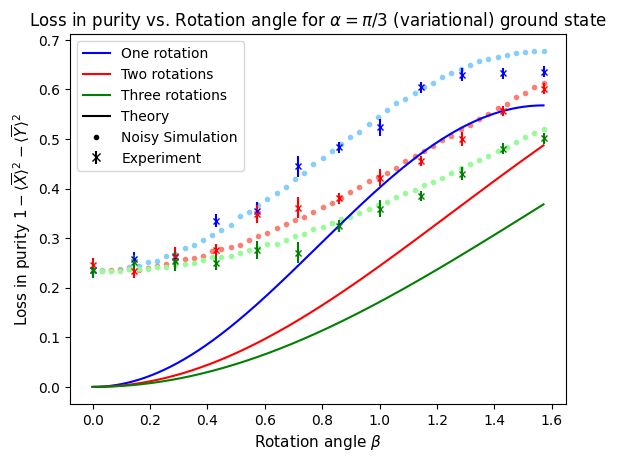

In [219]:
plt.plot(beta_ar_sim, one_rot_purity_sim, ".", color = "lightskyblue") #label="onerot purity, simulated")
plt.plot(beta_ar_sim, two_rot_purity_sim, ".", color = "salmon") #label = "tworot purity, simulated")
plt.plot(beta_ar_sim, three_rot_purity_sim, ".", color = "palegreen") #label="threerot purity, simulated")
plt.errorbar(beta_ar_coarse, one_rot_purity_coarse, yerr=one_rot_purity_coarse_err, fmt="x", color="blue", markersize=4) #label="onerot purity, exp")
plt.errorbar(beta_ar_coarse, two_rot_purity_coarse, yerr=one_rot_purity_coarse_err, fmt="x", color="red", markersize=4) #label = "tworot purity, exp")
plt.errorbar(beta_ar_coarse, three_rot_purity_coarse, yerr=one_rot_purity_coarse_err fmt="x", color="green", markersize=4) #label="threerot purity, exp")


plt.plot(beta_ar_smooth, purity_onerot_theory, "b-", label="One rotation")
plt.plot(beta_ar_smooth, purity_tworot_theory, "r-", label="Two rotations")
plt.plot(beta_ar_smooth, purity_threerot_theory, "g-", label="Three rotations")

plt.plot([], [], "k-", label="Theory")
plt.errorbar([], [], [], fmt="x", color="black", label="Experiment")
plt.plot([], [], "k.", label="Noisy Simulation")#, p=1.65% depol noise")
# plt.plot(beta_ar, tworot_purities_4, "b+", label="tworot (close) purity, pi/3")
# plt.plot(beta_ar, tworot_spaced_purities_4, "r+", label = "tworot (spaced) purity, pi/3")
# plt.plot(beta_ar, threerot_purities_4, "g+", label="threerot purity, pi/3")
plt.legend(loc="best", fontsize=10)
plt.title(r"Loss in purity vs. Rotation angle for $\alpha = \pi/3$ (variational) ground state", size=12)
plt.ylabel(r"Loss in purity $1 - \langle \overline{X} \rangle^2 - \langle \overline{Y} \rangle^2$", size=11)
plt.xlabel(r"Rotation angle $\beta$", size=11)
plt.savefig("figures/divideconquer_coarse.pdf")
plt.show()

In [ ]:
sim_data = np.load("processed_data/DaC_purities_fine_sim_optimal_p0105_4mshots.npz")
beta_ar_sim = sim_data["beta_ar"]
one_rot_purity_sim = sim_data["one_rot_purity_sim"]
two_rot_purity_sim = sim_data["two_rot_purity_sim"]
three_rot_purity_sim = sim_data["three_rot_purity_sim"]

In [160]:
beta_ar_smooth = np.linspace(0, 0.55, 1000)
SOP_theory = np.load("processed_data/VQE_N9_thetamin_and_SOP.npz")["SOP_val_ideal"]

purity_onerot_theory = np.ones(len(beta_ar_smooth)) - avgX(beta_ar_smooth, SOP_theory, 1)**2 - avgY(beta_ar_smooth, SOP_theory, 1)**2
purity_tworot_theory = np.ones(len(beta_ar_smooth)) - avgX(beta_ar_smooth/2, SOP_theory, 2)**2 - avgY(beta_ar_smooth/2, SOP_theory, 2)**2
purity_threerot_theory = np.ones(len(beta_ar_smooth)) - avgX(beta_ar_smooth/3, SOP_theory, 3)**2 - avgY(beta_ar_smooth/3, SOP_theory, 3)**2

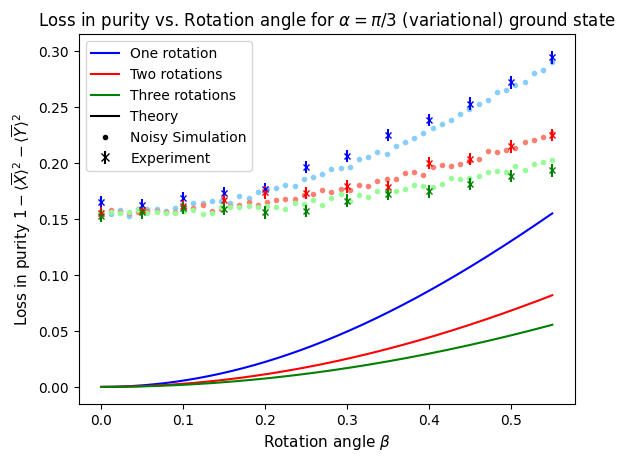

In [210]:
plt.plot(beta_ar_sim, one_rot_purity_sim, ".", color = "lightskyblue") #label="onerot purity, simulated")
plt.plot(beta_ar_sim, two_rot_purity_sim, ".", color = "salmon") #label = "tworot purity, simulated")
plt.plot(beta_ar_sim, three_rot_purity_sim, ".", color = "palegreen") #label="threerot purity, simulated")
plt.errorbar(beta_ar_fine, one_rot_purity_fine, yerr=one_rot_purity_fine_err, fmt="x", color="blue", markersize=4) #label="onerot purity, exp")
plt.errorbar(beta_ar_fine, two_rot_purity_fine, yerr=one_rot_purity_fine_err, fmt="x", color="red", markersize=4) #label = "tworot purity, exp")
plt.errorbar(beta_ar_fine, three_rot_purity_fine, yerr=one_rot_purity_fine_err, fmt="x", color="green", markersize=4) #label="threerot purity, exp")


plt.plot(beta_ar_smooth, purity_onerot_theory, "b-", label="One rotation")
plt.plot(beta_ar_smooth, purity_tworot_theory, "r-", label="Two rotations")
plt.plot(beta_ar_smooth, purity_threerot_theory, "g-", label="Three rotations")

plt.plot([], [], "k-", label="Theory")
plt.errorbar([], [], [], fmt="x", color="black", label="Experiment")
plt.plot([], [], "k.", label="Noisy Simulation")#, p=1.65% depol noise")
# plt.plot(beta_ar, tworot_purities_4, "b+", label="tworot (close) purity, pi/3")
# plt.plot(beta_ar, tworot_spaced_purities_4, "r+", label = "tworot (spaced) purity, pi/3")
# plt.plot(beta_ar, threerot_purities_4, "g+", label="threerot purity, pi/3")
plt.legend(loc="best", fontsize=10)
plt.title(r"Loss in purity vs. Rotation angle for $\alpha = \pi/3$ (variational) ground state", size=12)
plt.ylabel(r"Loss in purity $1 - \langle \overline{X} \rangle^2 - \langle \overline{Y} \rangle^2$", size=11)
plt.xlabel(r"Rotation angle $\beta$", size=11)
plt.savefig("figures/divideconquer_fine.pdf")
plt.show()

## Curve Fitting - extracting $1/N$ scaling

In [187]:
# Quadratic + constant offset
def quad_plusc(x, a, c):
    return a * x**2 + c

In [188]:
# Theory predictions - note that the actual curvatures measured will be diminished (due to combination of device noise and small angle approx) but the 1/N ratios will be preserved.

curvature = 1 - SOP_theory**2

onerot_curvature = curvature
tworot_curvature = curvature/2
threerot_curvature = curvature/3

theory_curvatures = [onerot_curvature, tworot_curvature, threerot_curvature]
theory_ratios = [1, 1/2, 1/3]

In [189]:
# Fit quadratics, obtain fitting parameters and errors

popt1, pcov1 = curve_fit(quad_plusc, beta_ar_fine, one_rot_purity_fine, sigma=one_rot_purity_fine_err, absolute_sigma=True)
m1, c1 = popt1
m1_err = np.sqrt(pcov1[0][0])
popt2, pcov2 = curve_fit(quad_plusc, beta_ar_fine, two_rot_purity_fine, sigma=two_rot_purity_fine_err, absolute_sigma=True)
m2, c2 = popt2
m2_err = np.sqrt(pcov2[0][0])
popt3, pcov3 = curve_fit(quad_plusc, beta_ar_fine, three_rot_purity_fine, sigma=three_rot_purity_fine_err, absolute_sigma=True)
m3, c3 = popt3
m3_err = np.sqrt(pcov3[0][0])

exp_curvatures = [m1, m2, m3]
exp_curvatures_err = [m1_err, m2_err, m3_err]

In [198]:
# Compute ratios
m1m1 = m1/m1
m1m1_err = m1m1 * np.sqrt((m1_err/m1)**2 + (m1_err/m1)**2)
m2m1 = m2/m1
m2m1_err = m2m1 * np.sqrt((m2_err/m2)**2 + (m1_err/m1)**2)
m3m1 = m3/m1
m3m1_err = m3m1 * np.sqrt((m3_err/m3)**2 + (m1_err/m1)**2)

exp_ratios = [m1m1, m2m1, m3m1]
exp_ratios_err = [m1m1_err, m2m1_err, m3m1_err]

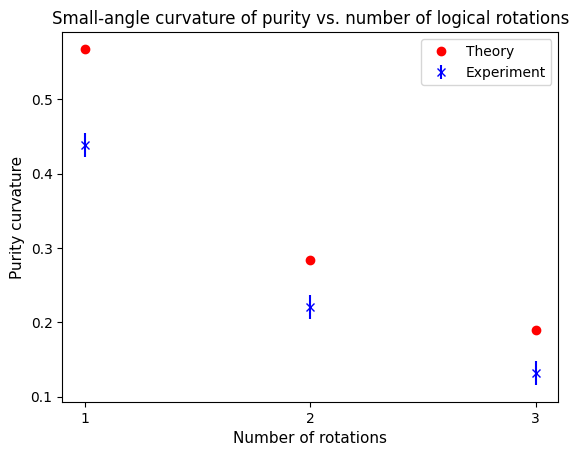

In [222]:
# Plotting curvatures
plt.plot([1, 2, 3], theory_curvatures, "ro", label="Theory")
plt.errorbar([1, 2, 3], exp_curvatures, yerr=exp_curvatures_err, fmt="x", color="blue", label="Experiment")
plt.xticks([1, 2, 3], [1, 2, 3])
plt.legend(loc="best", fontsize=10)
plt.xlabel("Number of rotations", size=11)
plt.ylabel("Purity curvature", size=11)
plt.title("Small-angle curvature of purity vs. number of logical rotations", size=12)
plt.savefig("figures/curvatures.pdf")

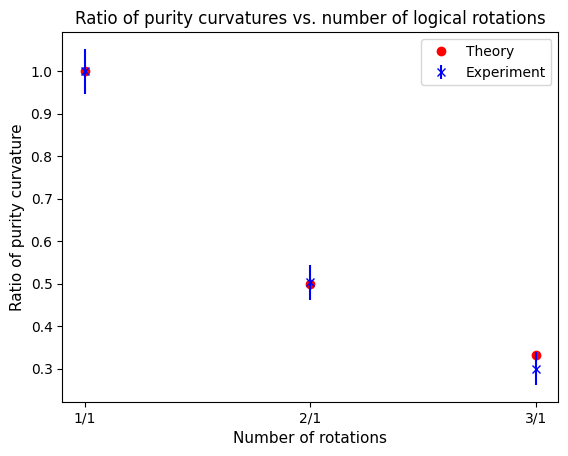

In [223]:
# Plotting curvatures
plt.plot([1, 2, 3], theory_ratios, "ro", label="Theory")
plt.errorbar([1, 2, 3], exp_ratios, yerr=exp_ratios_err, fmt="x", color="blue", label="Experiment")
plt.xticks([1, 2, 3], ["1/1", "2/1", "3/1"])
plt.legend(loc="best", fontsize=10)
plt.xlabel("Number of rotations", size=11)
plt.ylabel("Ratio of purity curvature", size=11)
plt.title("Ratio of purity curvatures vs. number of logical rotations", size=12)
plt.savefig("figures/curvature_ratios.pdf")